In [53]:
import os
import pickle
import numpy as np
from glob import glob
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

### DataHandler Class

This section of the notebook introduces the DataHandler class, which is crucial for preparing the MIDI data for training the music generation model. Below are the core functionalities provided by this class:

   - Initialization: Sets up the class with the default directory for MIDI files and the maximum number of files to process.
   - MIDI File Loading: Loads MIDI files from a specified directory. You can adjust the directory and the number of files to load as needed.
   - Note Extraction: Extracts musical elements such as notes and chords from the loaded MIDI files. This function is essential for creating the dataset that the model will learn from.
   - Sequence Preparation: Prepares sequences of musical notes that will be fed into the LSTM model. These sequences are used to train the network to predict the next musical note based on a given sequence of notes.

Each method in the DataHandler class plays a specific role in processing the data, ensuring that the input to the neural network is formatted correctly and is representative of the underlying musical structure. Now, let's delve into the implementation details of each method within the class.

In [54]:
class DataHandler:
    """Handles loading and processing MIDI data for training."""
    # Initialize the DataHandler with a default folder and number of files to process.
    def __init__(self, midi_folder='Data', num_files=20):
        self.midi_folder = midi_folder
        self.num_files = num_files

    # Load MIDI files from a specified directory, limiting the number to process.
    def load_midi_files(self):
        """Loads MIDI files from the specified folder up to a specified maximum number."""
        path = os.path.join(self.midi_folder, '*.mid')
        files = glob(path)
        return files[:self.num_files]

    # Extract notes and chords from MIDI files. 
    def get_notes(self):
        """Extracts notes and chords from MIDI files."""
        notes = []
        for file in self.load_midi_files():
            midi = converter.parse(file)
            parts = instrument.partitionByInstrument(midi)
            notes_to_parse = parts.parts[0].recurse() if parts else midi.flat.notes
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        return notes

    # Prepare sequences used by the Neural Network.
    def prepare_sequences(self, notes, sequence_length=100):
        """Prepares training sequences for the model."""
        pitchnames = sorted(set(notes))
        note_to_int = {note: number for number, note in enumerate(pitchnames)}
        network_input = []
        network_output = []
        
        for i in range(len(notes) - sequence_length):
            sequence_in = notes[i: i + sequence_length]
            sequence_out = notes[i + sequence_length]
            network_input.append([note_to_int[char] for char in sequence_in])
            network_output.append(note_to_int[sequence_out])
        
        n_patterns = len(network_input)
        network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
        network_input = network_input / float(len(pitchnames))
        network_output = to_categorical(network_output, num_classes=len(pitchnames))
        
        return network_input, network_output


## Neural Network Model with MusicModel Class

The MusicModel class encapsulates the creation and training of a neural network specifically designed for generating music. Here's an overview of the responsibilities and functionalities of this class:
   - Initialization: Configures the neural network parameters such as the number of LSTM units, dropout rates, and the number of units in the dense layer. It also sets the path where the model will be saved.
   - Network Creation: Constructs the LSTM network using the specified architecture. This includes adding LSTM layers with dropout for regularization and a dense output layer with softmax activation suitable for classification.
   - Model Training: Handles the training of the neural network, including saving the best-performing model during the training process.

The design of the MusicModel class allows for flexibility in adjusting the neural network architecture and training parameters. This makes it easier to experiment with different configurations to optimize performance for music generation tasks.

### Key Components of the MusicModel Class:
- LSTM Layers: Utilized for their ability to maintain long-term dependencies, making them ideal for sequence prediction tasks like music generation.
- Dropout: Applied to prevent overfitting by randomly dropping units during training.
- Dense Layers: Used to map the representations learned by the LSTM layers to the desired output size, which corresponds to the vocabulary of musical notes.

In [55]:
class MusicModel:
    """Builds and trains a neural network for music generation."""
    
    
    def __init__(self, model_path='Model', lstm_units=(128, 128), dropout_rates=(0.2, 0.3), dense_units=256):
        self.model_path = model_path
        self.lstm_units = lstm_units
        self.dropout_rates = dropout_rates
        self.dense_units = dense_units
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)

    
    def create_network(self, input_shape, n_vocab):
        """Creates the LSTM network model."""
        model = Sequential()
        model.add(Input(shape=input_shape))  # Explicit input layer
        model.add(LSTM(self.lstm_units[0], return_sequences=True))
        model.add(Dropout(self.dropout_rates[0]))
        model.add(LSTM(self.lstm_units[1]))
        model.add(Dropout(self.dropout_rates[1]))
        model.add(Dense(self.dense_units))
        model.add(Dense(n_vocab, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

    def train(self, network_input, network_output, epochs=50, batch_size=64):
        """Trains the model and saves the best performing model."""
        model = self.create_network((network_input.shape[1], network_input.shape[2]), network_output.shape[1])
        filepath = os.path.join(self.model_path, f'weights.best.music.keras')
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        model.fit(network_input, network_output, epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])


## Generating Music with the MusicGenerator Class

The MusicGenerator class is responsible for the application phase of the music generation process, utilizing a previously trained model to generate new music sequences. Here are the key functionalities of this class:

    - Initialization: Sets the path for the trained model and the output MIDI file.
    - Model Loading: Loads the pre-trained model from the specified path, enabling its use for generating music.
    - Music Generation: Uses the loaded model to generate a sequence of music notes based on a start pattern. This method includes advanced techniques to adjust the randomness and creativity of the generated music through the temperature parameter.
    - MIDI Creation: Converts the sequence of generated notes into a standard MIDI file that can be played with any MIDI-compatible software or hardware.

### Detailed Functionality:

- Load Model: Ensures the model with the best training performance is loaded for generating music.
- Generate Music: Starts with a random sequence of notes and iteratively predicts subsequent notes using the model, creating a full sequence based on initial conditions and learned patterns.
- Create MIDI: Translates the sequence of notes and chords into a MIDI file, adjusting timing and offsets to ensure musical coherence.

This class encapsulates all necessary steps to not just use a neural network model for prediction but to turn those predictions into audible music, demonstrating the practical application of machine learning in creative domains.

In [56]:
class MusicGenerator:
    """Generates music using the trained model."""
    
    def __init__(self, model_path='Model', output_path='Output/output.mid'):
        self.model_path = model_path
        self.output_path = output_path

    def load_model(self):
        """"Loads the trained model."""
        return load_model(os.path.join(self.model_path, 'weights.best.music.keras'))

    def generate_music(self, model, notes, n_vocab, length=500, temperature=1.0):
        """Generates a sequence of music notes."""
        int_to_note = {number: note for number, note in enumerate(sorted(set(notes)))}
        pattern = np.random.randint(0, n_vocab, size=(100,)).tolist()
        prediction_output = []

        for note_index in range(length):
            prediction_input = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
            prediction = model.predict(prediction_input, verbose=0).astype('float64')
            prediction = np.log(prediction + 1e-7) / temperature  # Smoothing
            exp_preds = np.exp(prediction)
            prediction = exp_preds / np.sum(exp_preds)
            index = np.random.choice(range(n_vocab), p=prediction[0])
            result = int_to_note[index]
            prediction_output.append(result)
            pattern.append(index)
            pattern = pattern[1:]

        return prediction_output
    
    def create_midi(self, prediction_output):
        """Converts the generated note sequence into a MIDI file."""
        offset = 0
        output_notes = []

        for pattern in prediction_output:
            # Handling chords
            if ('.' in pattern) or pattern.isdigit():
                notes_in_chord = pattern.split('.')
                notes = [note.Note(int(n)) for n in notes_in_chord]
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                output_notes.append(new_chord)
            else: # Handling single notes
                new_note = note.Note(pattern)
                new_note.offset = offset
                output_notes.append(new_note)

            offset += 0.5

        midi_stream = stream.Stream(output_notes)
        midi_stream.write('midi', fp=self.output_path)


## Playing Music with the MusicPlayer Class

The MusicPlayer class is designed to handle the playback of MIDI music files, providing a simple interface to listen to the music generated by the MusicGenerator class. Below is an explanation of the functionalities and usage of this class:

   - Initialization: Accepts the path to a MIDI file that will be played.
   - Play MIDI: Uses the music21 library to load and play the specified MIDI file in real-time.

### Key Features:

- Simple Interface: Designed to be straightforward with minimal setup required for playing MIDI files.
- Integration with music21: Leverages the powerful music21 toolkit to handle MIDI file operations and playback, ensuring compatibility and ease of use.

The MusicPlayer class simplifies the process of playing MIDI files, allowing users to experience the generated music without needing external applications. This functionality is essential for a complete end-to-end music generation and playback system within the Jupyter Notebook environment.

In [57]:
class MusicPlayer:
    """Plays MIDI music files."""
    def __init__(self, midi_file_path):
        self.midi_file_path = midi_file_path

    def play_midi(self):
        """Uses music21 to play a MIDI file."""
        from music21 import midi
        midi_stream = converter.parse(self.midi_file_path)
        sp = midi.realtime.StreamPlayer(midi_stream)
        sp.play()


## Implementing the Neural Network and Training It

In [58]:
"""Implementing the Neural Network and Training it"""
data_handler = DataHandler()

notes = data_handler.get_notes()
if len(notes) > 100:
    n_vocab = len(set(notes))
    network_input, network_output = data_handler.prepare_sequences(notes)

    model_trainer = MusicModel()
    model_trainer.train(network_input, network_output, epochs=200)

else:
    print("Not enough notes to proceed with training and music generation.")


Epoch 1/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 4.0555
Epoch 1: loss improved from inf to 3.91748, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - loss: 4.0546
Epoch 2/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 3.8215
Epoch 2: loss improved from 3.91748 to 3.80168, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - loss: 3.8214
Epoch 3/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.7557
Epoch 3: loss improved from 3.80168 to 3.75447, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - loss: 3.7557
Epoch 4/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 3.7356
Epoch 4: loss improved from 3.75447 to 3.71860, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - loss: 3.7355
Epoch 5/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 3.6862
Epoch 5: loss improved from 3.71860 to

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 2.8147
Epoch 29: loss improved from 2.90386 to 2.83813, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - loss: 2.8148
Epoch 30/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.7919
Epoch 30: loss improved from 2.83813 to 2.78470, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - loss: 2.7919
Epoch 31/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.7362
Epoch 31: loss improved from 2.78470 to 2.74644, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - loss: 2.7362
Epoch 32/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.7227
Epoch 32: loss improved from 2.74644 to 2.72779, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - loss: 2.7227
Epoch 33/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.6733
Epoch 33: loss improved from 2.72779 t

165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - loss: 2.0501
Epoch 58/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.0821
Epoch 58: loss improved from 2.10836 to 2.10514, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 2.0822
Epoch 59/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.0497
Epoch 59: loss improved from 2.10514 to 2.09032, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 2.0500
Epoch 60/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.0294
Epoch 60: loss improved from 2.09032 to 2.08148, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 2.0297
Epoch 61/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.0341
Epoch 61: loss improved from 2.08148 to 2.07650, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - loss: 2.0344
Epoch 62/200
165/165 ━━━━━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.6491
Epoch 87: loss improved from 1.74116 to 1.70109, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - loss: 1.6494
Epoch 88/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.6659
Epoch 88: loss improved from 1.70109 to 1.69714, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - loss: 1.6661
Epoch 89/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 1.6546
Epoch 89: loss did not improve from 1.69714
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - loss: 1.6550
Epoch 90/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.6821
Epoch 90: loss did not improve from 1.69714
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - loss: 1.6822
Epoch 91/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 1.6104
Epoch 91: loss improved from 1.69714 to 1.66393, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - 

165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - loss: 1.3804
Epoch 118/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.3682
Epoch 118: loss improved from 1.41864 to 1.41061, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - loss: 1.3685
Epoch 119/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.4313
Epoch 119: loss did not improve from 1.41061
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - loss: 1.4314
Epoch 120/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.3914
Epoch 120: loss did not improve from 1.41061
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - loss: 1.3915
Epoch 121/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.3740
Epoch 121: loss improved from 1.41061 to 1.40797, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - loss: 1.3742
Epoch 122/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.3828
Epoch 122: loss did not improve from 1.40797
165/165 ━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.1462
Epoch 148: loss improved from 1.19499 to 1.17757, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 1.1464
Epoch 149/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1.1414
Epoch 149: loss improved from 1.17757 to 1.17636, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - loss: 1.1416
Epoch 150/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.1378
Epoch 150: loss did not improve from 1.17636
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - loss: 1.1381
Epoch 151/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1.1718
Epoch 151: loss did not improve from 1.17636
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - loss: 1.1720
Epoch 152/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1.1963
Epoch 152: loss did not improve from 1.17636
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - loss: 1.1964
Epoch 153/200
165/165 ━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.9858
Epoch 179: loss did not improve from 1.01772
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - loss: 0.9860
Epoch 180/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.9805
Epoch 180: loss improved from 1.01772 to 1.01223, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - loss: 0.9807
Epoch 181/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.9742
Epoch 181: loss improved from 1.01223 to 1.01113, saving model to Model/weights.best.music.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - loss: 0.9744
Epoch 182/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.9960
Epoch 182: loss did not improve from 1.01113
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - loss: 0.9963
Epoch 183/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.0030
Epoch 183: loss did not improve from 1.01113
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - loss: 1.0034
Epoch 184/200
165/165 ━━━━━━━━

## Model Summary

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 122)            │        31,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,568 (3.00 MB)

 Trainable params: 262,522 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 525,046 (2.00 MB)

## Generating the Neural Network Architecture

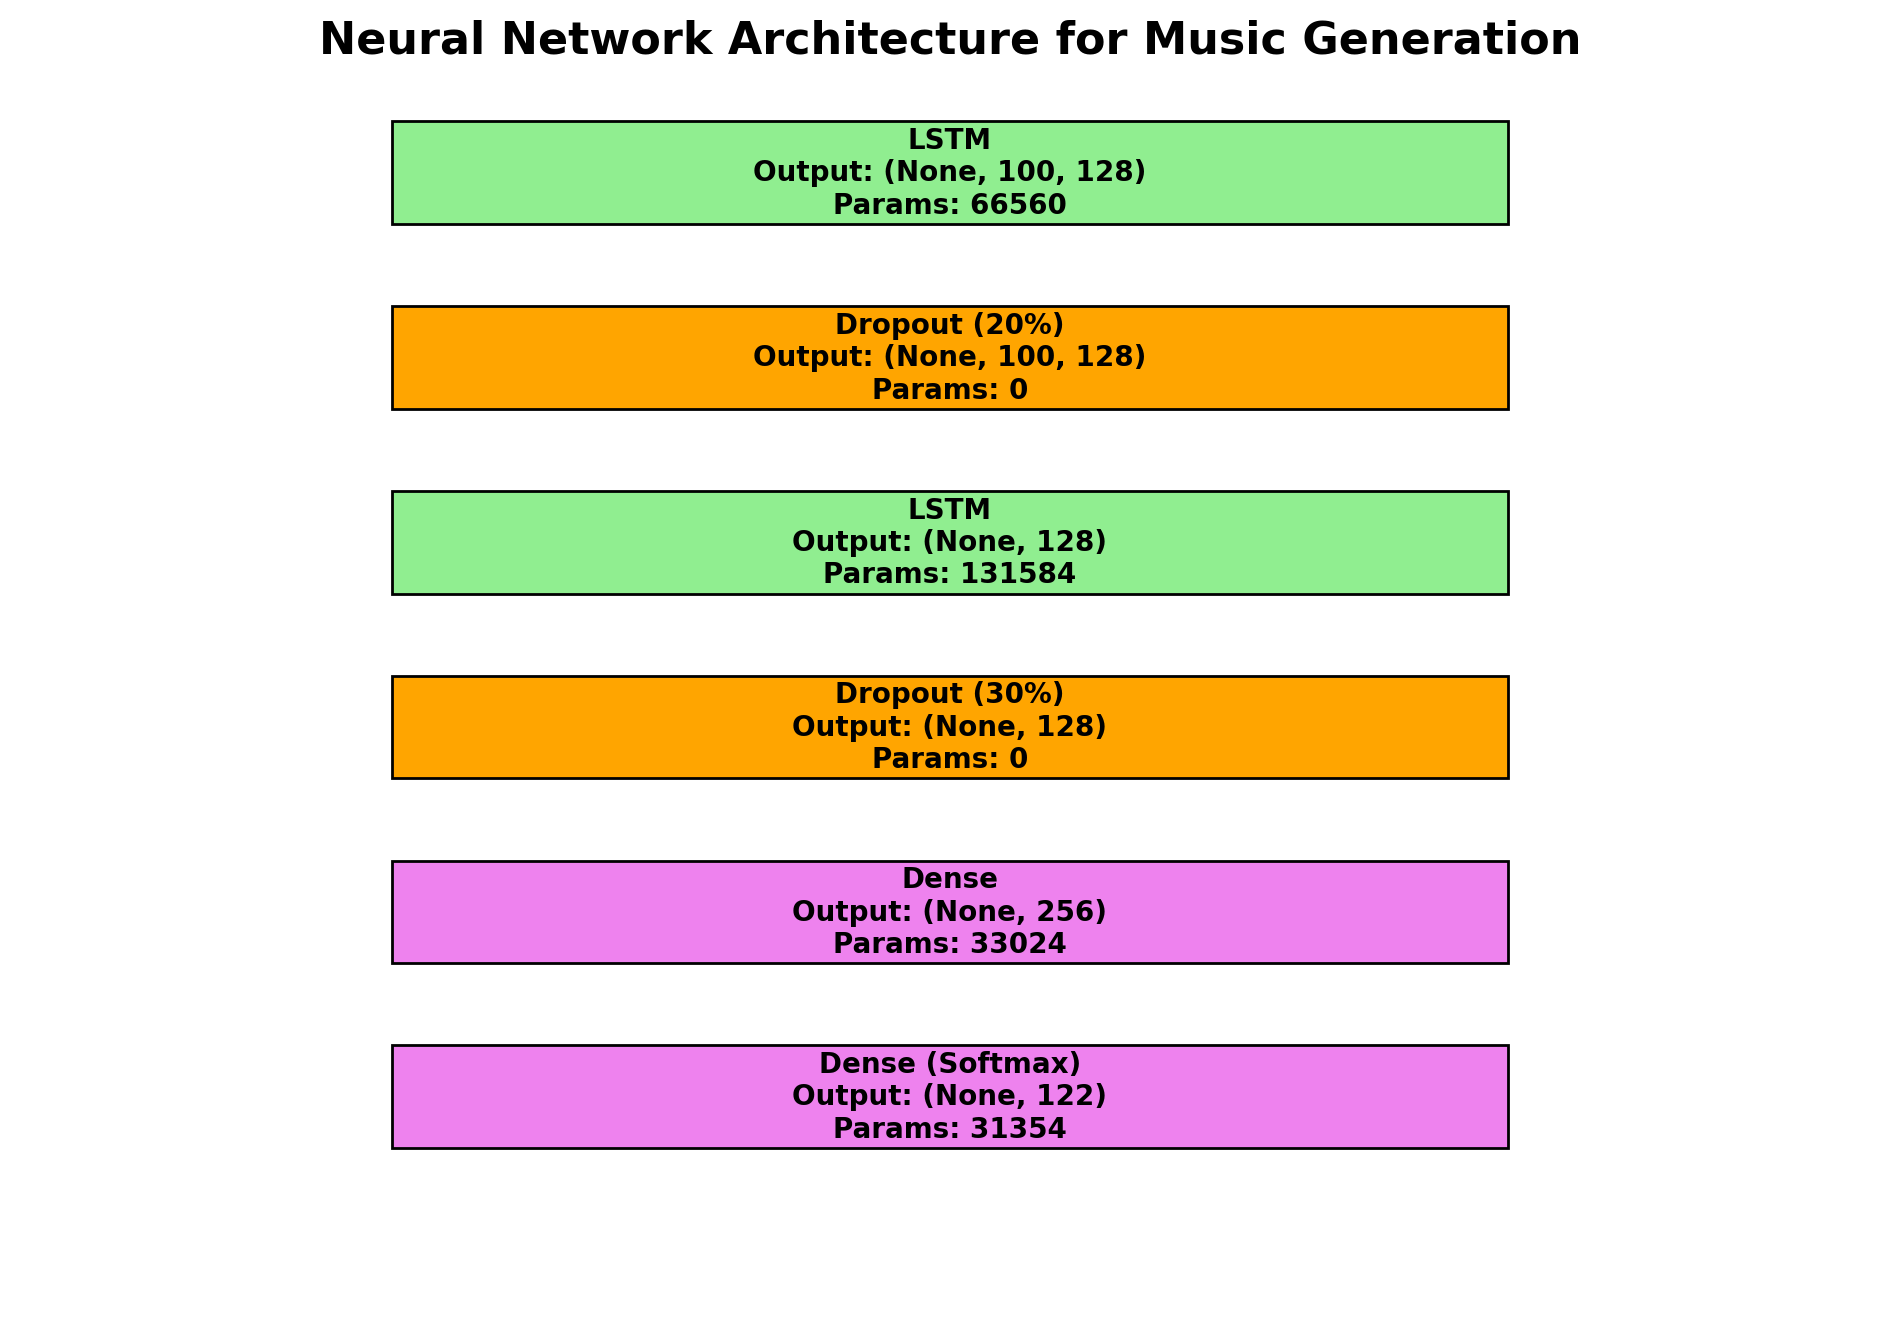

In [60]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12, 8))

updated_layers = [
    ("LSTM", "Output: (None, 100, 128)", 66560, {'edgecolor': 'black', 'facecolor': 'lightgreen'}),
    ("Dropout (20%)", "Output: (None, 100, 128)", 0, {'edgecolor': 'black', 'facecolor': 'orange'}),
    ("LSTM", "Output: (None, 128)", 131584, {'edgecolor': 'black', 'facecolor': 'lightgreen'}),
    ("Dropout (30%)", "Output: (None, 128)", 0, {'edgecolor': 'black', 'facecolor': 'orange'}),
    ("Dense", "Output: (None, 256)", 33024, {'edgecolor': 'black', 'facecolor': 'violet'}),
    ("Dense (Softmax)", "Output: (None, 122)", 31354, {'edgecolor': 'black', 'facecolor': 'violet'})
]


# Draw each layer as a rectangle with updated details
x, y = 0, 0  # Reset starting coordinates
for i, (label, output, params, style) in enumerate(updated_layers):
    # Draw rectangle
    rect = Rectangle((x, y - 0.5 * height), width, height, **style)
    ax.add_patch(rect)

    # Add text annotation for each layer including output shape and param count
    text_details = f'{label}\n{output}\nParams: {params}'
    ax.text(x + width/2, y, text_details, 
            verticalalignment='center', horizontalalignment='center', fontsize=10, fontweight='bold')

    # Move y coordinate for next layer
    y -= 1.8 * height

# Set limits and labels
ax.set_xlim(-1, 4)
ax.set_ylim(-11, 1)
ax.axis('off')

# Display the diagram
plt.title("Neural Network Architecture for Music Generation", fontsize=16, fontweight='bold')
plt.show()

## Generating Music and MIDI Output

This section demonstrates how to use a trained neural network to generate music and create a MIDI file:

- Extract Notes: Retrieve notes from stored MIDI files using data_handler.get_notes(), which will be used to generate new music.
- Load and Generate Music:
    - Load Model: Use music_gen.load_model() to load a pre-trained model. Optionally, specify a different model file if you don't want to use the default.
    - Generate Music: Call music_gen.generate_music() with the loaded model and notes to create a new music sequence.
    - Create MIDI File: Convert the generated music sequence into a MIDI file with music_gen.create_midi(), and save it to the specified output path.
    - Completion Notification: Print "Output Created!" to confirm the MIDI file has been successfully generated.

#### Note:
You can bypass extensive model training by specifying a path to a pre-trained model when calling music_gen.load_model(), making the process quicker and more efficient for testing different outputs.
Example:
model = music_gen.load_model('Model/weights.best.music.keras')


In [61]:
notes = data_handler.get_notes()
n_vocab = len(set(notes))

In [62]:
music_gen = MusicGenerator()
model = music_gen.load_model()
prediction_output = music_gen.generate_music(model=model, notes=notes, n_vocab=n_vocab)
music_gen.create_midi(prediction_output)
print("Output Created!")

Output Created!


## Play the generated music

In [63]:
player = MusicPlayer('Output/output.mid')

# player.play_midi()